# **Your Agentic AI Just Went Rogue. How can you Hit Rewind?**
#### Learn how to build Agentic AI that recovers from errors and lets you rewind to any point, ensuring flawless operation and deep insights into every decision

### Did you know that even the most advanced AI agents, without proper safeguards, can be as fragile as a house of cards? Imagine a complex multi-step AI workflow, perhaps assisting customers or automating intricate business processes. 
#### What happens when a single API call fails, or an unexpected input derails the entire operation? Traditionally, you'd be left scrambling, losing valuable context and potentially starting from scratch. 
#### We've all been there, staring at a stack trace, wishing we could just "go back in time" to see what went wrong, or that the system could simply pick up where it left off after a hiccup.
#### This blog explores LangGraph's fault tolerance and time travel features, which offer a robust safety net for AI applications, simplify debugging, enable graceful recovery, and provide unprecedented control.

In [ ]:
# !pip install langgraph langchain_openai

In [2]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver

In [3]:
from getpass import getpass
import os

os.environ['OPENAI_API_KEY'] = getpass()

llm = ChatOpenAI()

··········


In [4]:
class CountryState(TypedDict):

    country: str
    capital: str
    brief: str

In [5]:
def fetch_capital(state: CountryState):

    prompt = f'Find the capital of the country {state["country"]}'
    response = llm.invoke(prompt).content

    return {'capital': response}

In [6]:
def generate_brief(state: CountryState):

    prompt = f'write an brief on the capital in 25 words - {state["capital"]}'
    response = llm.invoke(prompt).content

    return {'brief': response}

In [7]:
graph = StateGraph(CountryState)

graph.add_node('fetch_capital', fetch_capital)
graph.add_node('generate_brief', generate_brief)

graph.add_edge(START, 'fetch_capital')
graph.add_edge('fetch_capital', 'generate_brief')
graph.add_edge('generate_brief', END)

checkpointer = InMemorySaver()

workflow = graph.compile(checkpointer=checkpointer)

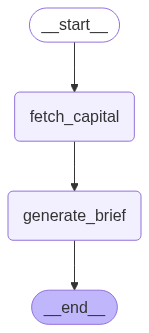

In [8]:
workflow

In [10]:
config1 = {"configurable": {"thread_id": "1"}}
workflow.invoke({'country':'India'}, config=config1)

{'country': 'India',
 'capital': 'New Delhi',
 'brief': 'New Delhi is the capital of India, known for its historical landmarks, diverse culture, and the seat of the government and political power in the country.'}

In [11]:
workflow.get_state(config1)

StateSnapshot(values={'country': 'India', 'capital': 'New Delhi', 'brief': 'New Delhi is the capital of India, known for its historical landmarks, diverse culture, and the seat of the government and political power in the country.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f29-baf2-6ae6-8002-dcb6ac343988'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-08-05T11:52:05.645760+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f29-b4d7-60b5-8001-aa26c64d341d'}}, tasks=(), interrupts=())

In [12]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'country': 'India', 'capital': 'New Delhi', 'brief': 'New Delhi is the capital of India, known for its historical landmarks, diverse culture, and the seat of the government and political power in the country.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f29-baf2-6ae6-8002-dcb6ac343988'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-08-05T11:52:05.645760+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f29-b4d7-60b5-8001-aa26c64d341d'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'country': 'India', 'capital': 'New Delhi'}, next=('generate_brief',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f29-b4d7-60b5-8001-aa26c64d341d'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-05T11:52:05.005294+00:00', parent_config={'configurable': {'thread_id': '1', 'check

# **Updating the state**

In [13]:
workflow.update_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f071f29-b1e2-6b1c-8000-0ada42529435", "checkpoint_ns": ""}}, {'country':'Russia'})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f071f2f-8a5e-6a2a-8001-4d8b40dd6b8d'}}

In [14]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'country': 'Russia'}, next=('fetch_capital',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f2f-8a5e-6a2a-8001-4d8b40dd6b8d'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-08-05T11:54:41.613237+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f29-b1e2-6b1c-8000-0ada42529435'}}, tasks=(PregelTask(id='65a36b73-9ffc-37cd-b76e-0c0ecf0471b6', name='fetch_capital', path=('__pregel_pull', 'fetch_capital'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'country': 'India', 'capital': 'New Delhi', 'brief': 'New Delhi is the capital of India, known for its historical landmarks, diverse culture, and the seat of the government and political power in the country.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f29-baf2-6ae6-8002-dcb6ac343988'}}, metadata={'

In [15]:
workflow.invoke(None, {"configurable": {"thread_id": "1", "checkpoint_id": "1f071f2f-8a5e-6a2a-8001-4d8b40dd6b8d"}})

{'country': 'Russia',
 'capital': 'The capital of Russia is Moscow.',
 'brief': 'Moscow is the capital of Russia. Located in the western part of the country, it is the political and cultural center.'}

In [16]:
list(workflow.get_state_history(config1))

[StateSnapshot(values={'country': 'Russia', 'capital': 'The capital of Russia is Moscow.', 'brief': 'Moscow is the capital of Russia. Located in the western part of the country, it is the political and cultural center.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f32-3c66-6a33-8003-542d57f38f79'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-08-05T11:55:53.968252+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f32-3569-61b5-8002-485127840f62'}}, tasks=(), interrupts=()),
 StateSnapshot(values={'country': 'Russia', 'capital': 'The capital of Russia is Moscow.'}, next=('generate_brief',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071f32-3569-61b5-8002-485127840f62'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-08-05T11:55:53.235256+00:00', parent_config={'configurable': {'thread_id': 

# **Time Travel**

#### LangGraph's time travel feature, powered by robust checkpointing, enables users to rewind time to understand complex AI agent decisions. It allows inspection of agent state, replaying specific steps, and even "forking" execution to explore alternative paths, making it a valuable tool in complex AI systems.
#### Gaining unparalleled visibility into your AI's "thought process" is not just about traditional debugging; it involves imagining an agent making suboptimal decisions. With time travel, you can:
#### * Review historical states: See the exact state (messages, tools called, data) at each node execution.
#### * Replay from any point: Restart the workflow from a specific checkpoint, perhaps after tweaking a prompt or a tool's logic, to see if the outcome changes.

#### First, let's take a look at the workflow's state. We asked for the capital of India, and as you can see, the result came back just as we expected.

In [65]:
workflow.get_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f071cba-7c01-67ea-8004-3ccaef6e7005"}})

StateSnapshot(values={'country': 'India', 'capital': 'New Delhi', 'brief': 'New Delhi is the capital city of India, known for its historic landmarks, vibrant culture, and government buildings, serving as the political center of the country.'}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f071cba-7c01-67ea-8004-3ccaef6e7005'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-08-05T07:13:15.516891+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071cba-7645-6f32-8003-82b780af153e'}}, tasks=(), interrupts=())

In [66]:
workflow.get_state({"configurable": {"thread_id": "1", "checkpoint_id": "1f071cba-7645-6f32-8003-82b780af153e"}})

StateSnapshot(values={'country': 'India', 'capital': 'New Delhi'}, next=('generate_brief',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f071cba-7645-6f32-8003-82b780af153e'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-08-05T07:13:14.915781+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f071cba-6b43-64dd-8002-c1a4797643d9'}}, tasks=(PregelTask(id='d77763e4-f9e5-2e48-ac2a-e96fd9f0be1f', name='generate_brief', path=('__pregel_pull', 'generate_brief'), error=None, interrupts=(), state=None, result={'brief': 'New Delhi is the capital city of India, known for its historic landmarks, vibrant culture, and government buildings, serving as the political center of the country.'}),), interrupts=())

# **Fault Tolerance**

#### LangGraph offers built-in fault tolerance in AI workflows, allowing agents to continue from where they left off. This is achieved through intelligent state management and checkpointing, which maintains a dynamic, shared state that updates with every step in the workflow. This state can hold vital data, conversation history, search results, or complex decision stages.
#### LangGraph's checkpointing feature saves your AI's progress at key moments. This keeps your agent from collapsing, so it can pick up right where it left off even after a failure. This reduces wasted computation, smooths the user experience, and makes AI applications more robust. This feature is a significant improvement over traditional systems that often require a full restart, losing all progress.
#### To show this in action, we'll simulate a failure. We'll deliberately interrupt the workflow, then restart it later. This will demonstrate how LangGraph doesn't just start over from the beginning but resumes right where it left off.

In [17]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict
import time

In [84]:
# 1. Define the state
class CrashState(TypedDict):
    input: str
    step1: str
    step2: str

In [101]:
# 2. Define steps
def step_1(state: CrashState) -> CrashState:
    print("✅ Step 1 executed")
    return {"Stage  1": "Completed", "input": state["input"]}

def step_2(state: CrashState) -> CrashState:
    print("⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)")
    time.sleep(50)  # Simulate long-running hang
    return {"Stage 2": "Completed"}

def step_3(state: CrashState) -> CrashState:
    print("✅ Stage 3 executed")
    return {"Completed": True}

In [102]:
# 3. Build the graph
builder = StateGraph(CrashState)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)

builder.set_entry_point("step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

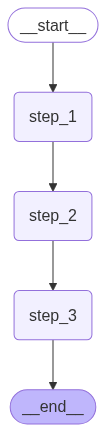

In [92]:
graph

In [103]:
try:
    print("▶️ Running graph: Please manually interrupt during Step 2...")
    graph.invoke({"input": "start"}, config={"configurable": {"thread_id": 'thread-1'}})
except KeyboardInterrupt:
    print("❌ Kernel manually interrupted (crash simulated).")

▶️ Running graph: Please manually interrupt during Step 2...
✅ Step 1 executed
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
❌ Kernel manually interrupted (crash simulated).


In [96]:
list(graph.get_state_history({"configurable": {"thread_id": 'thread-1'}}))

[StateSnapshot(values={'input': 'start', 'step1': 'done'}, next=('step_2',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f071d10-b5df-6b8a-8001-215720fd20ae'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-08-05T07:51:50.129732+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f071d10-b5dc-61ed-8000-a8d9fcede4f2'}}, tasks=(PregelTask(id='369f4aab-cf78-5b19-b500-28e589ebac06', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(), state=None, result=None),), interrupts=()),
 StateSnapshot(values={'input': 'start'}, next=('step_1',), config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'checkpoint_id': '1f071d10-b5dc-61ed-8000-a8d9fcede4f2'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-08-05T07:51:50.128256+00:00', parent_config={'configurable': {'thread_id': 'thread-1', 'checkpoint_ns': '', 'ch

In [104]:
# 6. Re-run to show fault-tolerant resume
print("\n🔁 Re-running the graph to demonstrate fault tolerance...")
final_state = graph.invoke(None, config={"configurable": {"thread_id": 'thread-1'}})
print("\n✅ Final State:", final_state)


🔁 Re-running the graph to demonstrate fault tolerance...
⏳ Step 2 hanging... now manually interrupt from the notebook toolbar (STOP button)
✅ Step 3 executed

✅ Final State: {'input': 'start', 'step1': 'done'}


# **Conclusion**
#### LangGraph is a powerful tool that revolutionizes the process of building AI agents. Its error handling and time travel features enable the creation of complex systems that resist problems and allow for thorough review of past actions. 
#### This provides deep insight and control, enabling agents to recover smoothly and retain crucial information. LangGraph also aids in analyzing AI decisions, boosting performance, and tracking compliance steps, allowing for more efficient AI development.
#### I highly encourage you to explore LangGraph's official documentation, experiment with the code examples we've discussed, and even try building a small, fault-tolerant agent of your own. Let me know in the comments about your experiments and learnings.